# Ultrasound Nerve Segmentation
[Kaggle Competition Link](https://www.kaggle.com/c/ultrasound-nerve-segmentation)

Semantic segmentation of ultrasound images to identify nerve structures to improve catheter placement and contribute to a more pain free future.

In [1]:
import os
import glob
import random
import re
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
from keras.models import load_model
from keras.models import model_from_yaml
from keras.applications.vgg16 import VGG16
import keras.applications.vgg16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dropout, Add, Flatten, Dense, Reshape, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras import backend as K
from keras import regularizers
from keras import losses
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import TruncatedNormal
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.utils import Sequence

/home/anand/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/anand/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# To ensure GPU is being used
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2661144225867427705
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7591201997
locality {
  bus_id: 1
}
incarnation: 2669274915544881928
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
IMAGE_HT = 416
IMAGE_WD = 576
data_dir = './data/'

## Transfer learning
Load pre-trained VGG16 model that is trained on ImageNet data.

In [5]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMAGE_HT, IMAGE_WD, 3))
FROZEN_LAYERS = 15
# Freeze layers
for idx,layer in enumerate(base_model.layers):
  layer.trainable = idx >= FROZEN_LAYERS

base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 576, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 576, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 576, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 288, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 288, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 288, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 104, 144, 128)     0         
__________

## FCN
- Add deconvolutions
- Add skip-connections
- Do softmax to convert logits to prob. distribution
- Reshape to [batch_size, image_width * image_height, num_classes]

In [6]:
num_classes = 1

regularizer = regularizers.l2(0.01)

x = base_model.output

x = Conv2D(filters=num_classes, kernel_size=1, strides=1, padding='SAME', activation=None, kernel_regularizer=regularizer)(x)

x = Conv2DTranspose(filters=512, kernel_size=4, strides=2, padding='SAME', activation=None, kernel_regularizer=regularizer)(x)

x = Add()([x, base_model.get_layer('block4_pool').output])

x = Conv2DTranspose(filters=256, kernel_size=4, strides=4, padding='SAME', activation=None, kernel_regularizer=regularizer)(x)

x = Add()([x, base_model.get_layer('block3_conv3').output])

x = Conv2DTranspose(filters=num_classes, kernel_size=5, strides=4, padding='SAME', activation='sigmoid', kernel_regularizer=regularizer)(x)

logits = Reshape((-1, num_classes))(x)

model = Model(inputs=base_model.input, outputs=logits)

## Loss function
- Define custom loss function to do calculate cross-entropy
- Dice coefficient loss used to train model - is a similarity index

In [7]:
def dice_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def loss_fn_other(y_true, y_pred):
    return K.mean(K.categorical_crossentropy(y_true, y_pred, from_logits=False), axis=1)
    #return K.stack( (K.sum(K.all((t1s,p0s), axis=0), axis=1), K.sum(K.all((t1s,p0s), axis=0), axis=1)) )
    #return K.sum(K.square(y_true[:,0:239616] * (1. - y_pred[:,0:239616])), axis=1) 
    #return K.sum(K.square(y_pred[:,0:239616] - y_true[:,0:239616]) + K.square(y_true[:,0:239616] * (1. - y_pred[:,0:239616])) * 100), axis=1)
    #return K.sum(K.square(y_pred - y_true), axis=1)
    #return K.mean(K.categorical_crossentropy(y_true, y_pred, from_logits=False), axis=1)

## Model compilation
- Select Adam optimizer
- Select custom loss function

In [8]:
learning_rate = 1e-5
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 576, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 416, 576, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 416, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 208, 288, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

## Training data generators
- Load images
- Split into training and validation sets (80/20 split)
- Select images with nerve-structures in them, skip blank images

In [9]:
filelist = glob.glob('./data/train_orig/*_mask.tif')

val_percent = 20
val_items = 20*len(filelist)//100

random.shuffle(filelist)

validation_list = filelist[0: val_items]
train_list = filelist[val_items:]
background_color = np.array([255, 255, 255])

class DataGenerator(Sequence):
    
    def isAllBlack(self, x):
        return np.all(self.imread(x)[:,:] == [0,0,0])
    
    def __init__(self, mask_list, batch_size, input_preprocessor):
        mask_notall_black = [x for x in mask_list if not self.isAllBlack(x)]
        self.y = mask_notall_black
        self.x = [grp.group(1)+grp.group(2) for grp in [re.match(r'(.*)_mask(\.tif)', x) for x in mask_notall_black]]
        self.batch_size = batch_size
        self.input_preprocessor = input_preprocessor
        
    def __len__(self):
        return math.ceil(len(self.x) / float(self.batch_size))
    
    def imread(self, file_name):
        return cv2.imread(file_name)[2: 418, 2:578]
    
    def inputimage(self, file_name):
        return self.input_preprocessor(self.imread(file_name).astype(np.float32))
    
    def labelread(self, file_name):
        img = self.imread(file_name)
        
        gt_bg = np.all(img == background_color, axis=2)
        gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
        
        class1 = np.zeros(gt_bg.shape)
        class1[gt_bg] = 1.
        return class1.reshape(-1, num_classes)
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]
       
        return np.array([self.inputimage(file_name) for file_name in batch_x]), np.array([self.labelread(file_name) for file_name in batch_y])
    


## Training and validation data
Create data generators for training and validation for specific batch size

In [10]:
batch_size = 10
train_gen = DataGenerator(train_list, batch_size, input_preprocessor = keras.applications.vgg16.preprocess_input)
val_gen = DataGenerator(validation_list, batch_size, input_preprocessor = keras.applications.vgg16.preprocess_input)

## Train model

In [11]:
epochs = 10
saveWeights = ModelCheckpoint(filepath='./data/weights.hdf5', verbose=1, save_best_only=True)
model.fit_generator(train_gen, validation_data = val_gen, epochs=epochs, callbacks=[saveWeights])

Epoch 1/10
185/186 [============================>.] - ETA: 0s - loss: 3.0141 - dice_coef: 0.0581
Epoch 00001: val_loss improved from inf to 2.63308, saving model to ./data/weights.hdf5
186/186 [==============================] - 72s 387ms/step - loss: 3.0121 - dice_coef: 0.0581 - val_loss: 2.6331 - val_dice_coef: 0.0617
Epoch 2/10
185/186 [============================>.] - ETA: 0s - loss: 2.3165 - dice_coef: 0.0635
Epoch 00002: val_loss improved from 2.63308 to 2.01511, saving model to ./data/weights.hdf5
186/186 [==============================] - 69s 373ms/step - loss: 2.3149 - dice_coef: 0.0636 - val_loss: 2.0151 - val_dice_coef: 0.0679
Epoch 3/10
185/186 [============================>.] - ETA: 0s - loss: 1.7628 - dice_coef: 0.0718
Epoch 00003: val_loss improved from 2.01511 to 1.52097, saving model to ./data/weights.hdf5
186/186 [==============================] - 70s 376ms/step - loss: 1.7616 - dice_coef: 0.0718 - val_loss: 1.5210 - val_dice_coef: 0.0791
Epoch 4/10
185/186 [=========

## Test trained model
- Plot 10 samples from validation set
- Left: input ultrasound image
- Middle: prediction by model
- Right: label

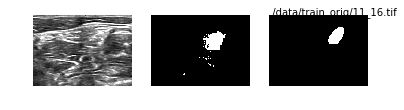

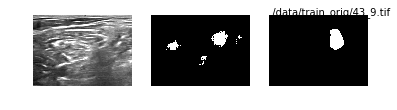

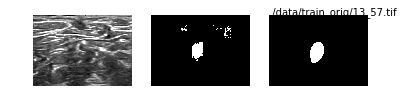

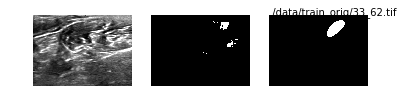

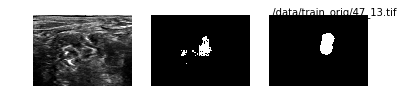

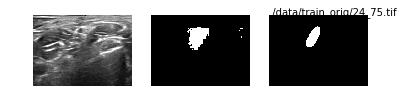

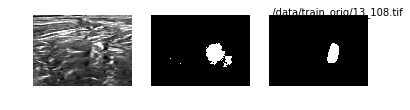

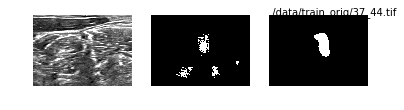

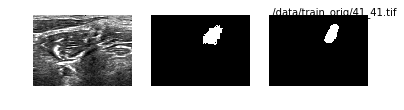

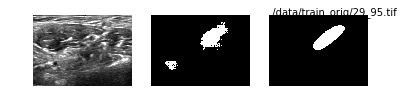

In [12]:
%matplotlib inline

sample_batch = DataGenerator(validation_list, 1, input_preprocessor = keras.applications.vgg16.preprocess_input)

for idx in range(10):
    X, label = sample_batch[idx]
    pred = model.predict(X).reshape(IMAGE_HT, IMAGE_WD)
    y=np.zeros(pred.shape)
    y[pred > 0] = 255
    
    plt.figure()
    
    img = sample_batch.imread(sample_batch.x[idx])
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(y, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.imshow(label.reshape(IMAGE_HT, IMAGE_WD), cmap='gray')
    
    plt.text(0, 0, sample_batch.x[idx], fontsize=10)